5/1/2022

Testing out new module.

In [2]:
using Revise

In [3]:
using JuliaSpectra
using BenchmarkTools
using Parameters
using NamedTupleTools
using CompositeStructs
using Plots

┌ Info: Precompiling JuliaSpectra [3ef6d832-bae6-4172-b279-153036e5bc42]
└ @ Base loading.jl:1423
┌ Warning: Replacing docs for `JuliaSpectra.X :: Union{}` in module `JuliaSpectra`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `JuliaSpectra.X :: Union{}` in module `JuliaSpectra`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `JuliaSpectra.X :: Union{}` in module `JuliaSpectra`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `JuliaSpectra.X :: Union{}` in module `JuliaSpectra`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `JuliaSpectra.X :: Union{}` in module `JuliaSpectra`
└ @ Base.Docs docs/Docs.jl:240


In [4]:
const sol = 299792458
const h = 6.626e-34
const ħ = h / 2π
const μB = 4.66989733e-5 # in cm^-1/Gauss.
;

# YbOH

In [5]:
@unpack B, γ, bF, c = MolParams["YbOH"]["X"]
const BX = B
const γX = γ
const bFX = bF
const cX = c

@unpack B, aSO, p2q, T0 = MolParams["YbOH"]["A"]
const BA = B
const ASO = aSO
const p2qA = p2q
const T0_A = T0
;

In [13]:
# Build ground state
Hrot = BX * Rotation
Hsr = γX * SpinRotation
HX = Hrot+Hsr
bounds_X = (J = 1/2:101/2, I=1/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)
ground = makeBlockedState(LinearCaseA, HX, bounds_X, :F, 0:30)

# Build excited state
Ho = T0_A * Origin
Hrot = BA * Rotation
HSO = ASO * SpinOrbit
Hld = p2qA * ΛDoubling_p2q
HA = Ho+Hrot+HSO+Hld
bounds_A = (J = 1/2:101/2, I=1/2, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2,3/2,-3/2],S = 1/2)
excited = makeBlockedState(LinearCaseA, HA, bounds_A, :F, 0:30)

# Make linelist
lout = makeLineList(ground,excited; TK=20)
;

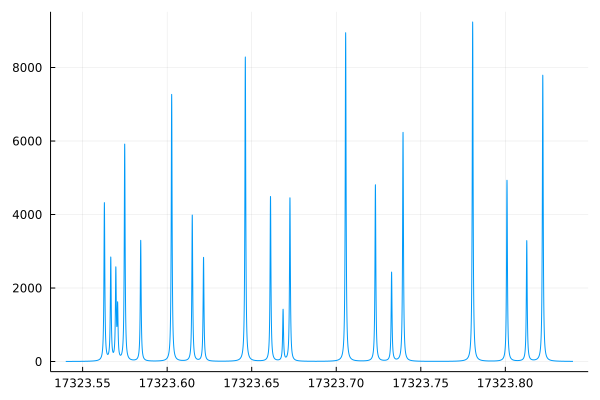

In [14]:
freq, amp = plotLineList(lout, 17323.54, 17323.84; gamma=0.0006, nstep= 9000)
plot(freq,amp)
plot!(legend=false)

## Zeeman simulation

  4.582336 seconds (31.69 M allocations: 1.736 GiB, 6.40% gc time, 45.33% compilation time)


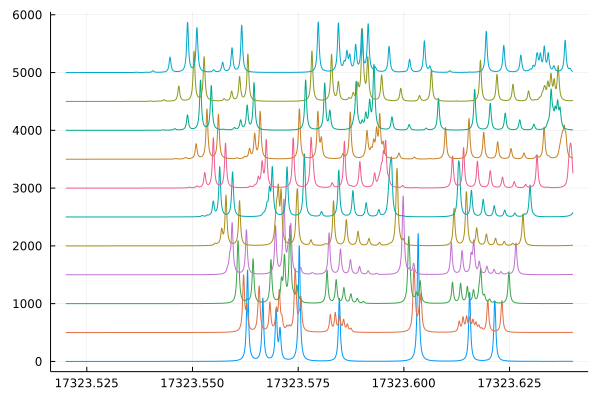

In [15]:
# Build ground state
@unpack B, γ, gS, bF, c = MolParams["YbOH"]["X"]

Hrot = B * Rotation
Hsr = γ * SpinRotation
Hhf = bF * Hyperfine_IF + c * Hyperfine_Dipolar_c
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr+Hhf
bounds_X = (J = 1/2:133/2, I=1/2, F=0:6, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, aSO, p2q, gS, gL, gl′ = MolParams["YbOH"]["A"]

Ho = T0 * Origin
Hrot = B * Rotation
HSO = aSO * SpinOrbit
Hld = p2q * ΛDoubling_p2q
HA_zeem = gS*Zeeman_S + gL*Zeeman_L + gl′*Zeeman_parity
HA = Ho+Hrot+HSO+Hld 
bounds_A = (J = 1/2:133/2, I=1/2, F = 0:6, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2],S = 1/2)


plot()
g_save = []
e_save = []
Bfields = range(0.0, step=50.0, length=11)
@time for (nB,B) = enumerate(Bfields)
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -4:4)
    excited = makeBlockedState(LinearCaseA_Field, HA+μB*B*HA_zeem, bounds_A, :M, -4:4)

    push!(g_save, ground)
    push!(e_save, excited)

    # Make linelist
   lout = makeLineList(ground,excited,"par"; TK=8)
   freq, amp = plotLineList(lout, 17323.52, 17323.64; gamma=0.0005, nstep= 5000)
   plot!(freq, amp .+ 500*(nB-1))
end

plot!(legend=false)




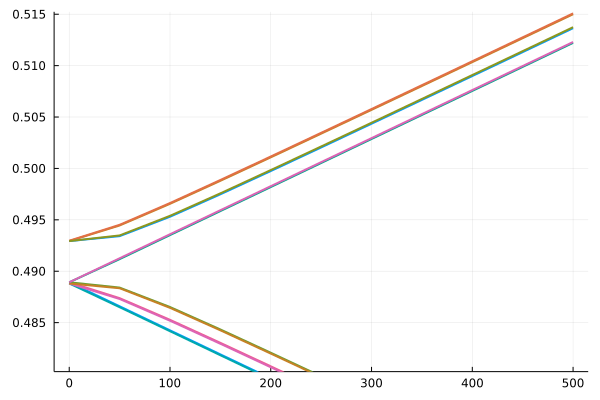

In [16]:
plot()
for M = -2:2
    plot!(Bfields,reduce(hcat,[g_save[i][M].evals for i in 1:length(g_save)])', lw=2)
end
plot!(legend=false)
plot!(ylims=(2*BX-0.01, 2*BX+0.025))
#plot!(xlims=(0,5))

# SrOH

## A-X band

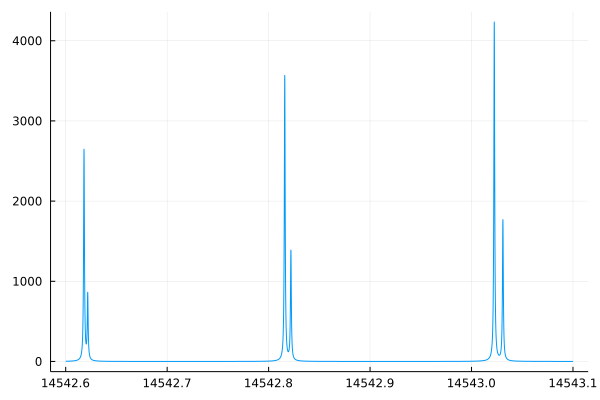

In [17]:
# Build ground state
@unpack B, γ = MolParams["SrOH"]["X000"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
HX = Hrot+Hsr
bounds_X = (I=1/2, J=1/2:101/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)
ground = makeBlockedState(LinearCaseA, HX, bounds_X, :F, 0:5)

# Build excited state
@unpack T0, B, aSO, p2q = MolParams["SrOH"]["A000"]
Ho = T0 * Origin
Hrot = B * Rotation
HSO = aSO * SpinOrbit
Hld = p2q * ΛDoubling_p2q
HA = Ho+Hrot+HSO+Hld
bounds_A = (I=1/2, J=1/2:101/2, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2,3/2,-3/2],S = 1/2)
excited = makeBlockedState(LinearCaseA, HA, bounds_A, :F, 0:5)

# Make linelist
lout = makeLineList(ground,excited, 0)

freq, amp = plotLineList(lout, 14542.6, 14543.1; gamma=0.001, nstep= 9000)
plot(freq,amp)
plot!(legend=false)

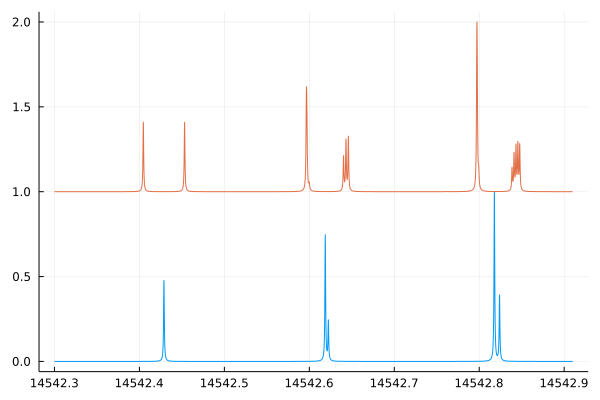

In [19]:
# Build ground state
@unpack B, γ, gS = MolParams["SrOH"]["X000"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr 
bounds_X = (J = 1/2:13/2, I=1/2, F=0:6, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, aSO, p2q, gS, gL, gl′ = MolParams["SrOH"]["A000"]
Ho = T0 * Origin
Hrot = B * Rotation
HSO = aSO * SpinOrbit
Hld = p2q * ΛDoubling_p2q
HA_zeem = gS*Zeeman_S + gL*Zeeman_L + gl′*Zeeman_parity
HA = Ho+Hrot+HSO+Hld 
bounds_A = (J = 1/2:13/2, I=1/2, F = 0:5, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2],S = 1/2)


plot()
for (nB,B) = enumerate(range(0, step=477.0, length=2))
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -5:5)
    excited = makeBlockedState(LinearCaseA_Field, HA+μB*B*HA_zeem, bounds_A, :M, -5:5)

    # Make linelist
   lout = makeLineList(ground,excited,"perp"; TK=10)
   freq, amp = plotLineList(lout, 14542.3, 14542.91; gamma=0.001, nstep= 5000)
   plot!(freq, amp/maximum(amp) .+ 1*(nB-1))
end

plot!(legend=false)


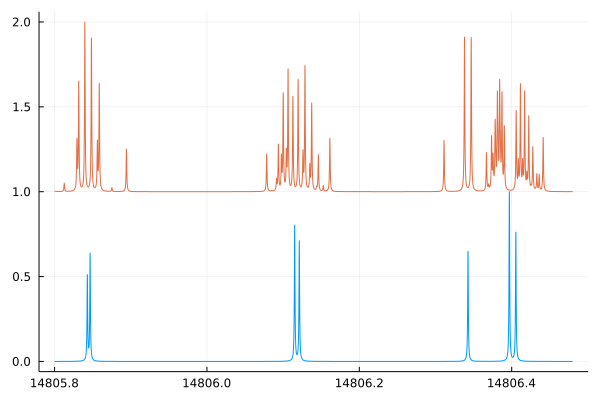

In [20]:
# Build ground state
@unpack B, γ, gS = MolParams["SrOH"]["X000"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr 
bounds_X = (J = 1/2:13/2, I=1/2, F=0:9, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, aSO, p2q, gS, gL, gl′ = MolParams["SrOH"]["A000"]
Ho = T0 * Origin
Hrot = B * Rotation
HSO = aSO * SpinOrbit
Hld = p2q * ΛDoubling_p2q
HA_zeem = gS*Zeeman_S + gL*Zeeman_L + gl′*Zeeman_parity
HA = Ho+Hrot+HSO+Hld 
bounds_A = (J = 1/2:13/2, I=1/2, F = 0:9, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2, 3/2, -3/2],S = 1/2)


plot()
for (nB,B) = enumerate(range(0, step=477.0, length=2))
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -7:7)
    excited = makeBlockedState(LinearCaseA_Field, HA+μB*B*HA_zeem, bounds_A, :M, -7:7)

    # Make linelist
   lout = makeLineList(ground,excited,"perp"; TK=10)
   freq, amp = plotLineList(lout, 14805.8, 14806.48; gamma=0.001, nstep= 50000)
   plot!(freq, amp/maximum(amp) .+ 1*(nB-1))
end

plot!(legend=false)

## B-X band

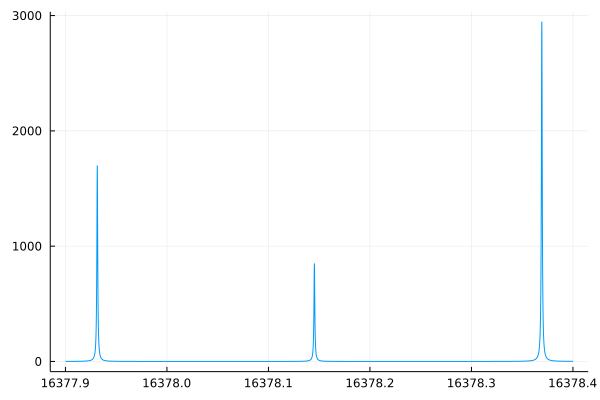

In [21]:
# Build ground state
@unpack B, γ = MolParams["SrOH"]["X000"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
HX = Hrot+Hsr
bounds_X = (I=1/2, J=1/2:101/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)
ground = makeBlockedState(LinearCaseA, HX, bounds_X, :F, 0:5)

# Build excited state
@unpack T0, B, γ = MolParams["SrOH"]["B000"]
Ho = T0 * Origin
Hrot = B * Rotation
Hsr = γ * SpinRotation
HB = Ho+Hrot+Hsr
bounds_B = (I=1/2, J=1/2:101/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)
excited = makeBlockedState(LinearCaseA, HB, bounds_B, :F, 0:5)

# Make linelist
lout = makeLineList(ground,excited, 0)

freq, amp = plotLineList(lout, 16377.9,16378.4; gamma=0.001, nstep= 9000)
plot(freq,amp)
plot!(legend=false)

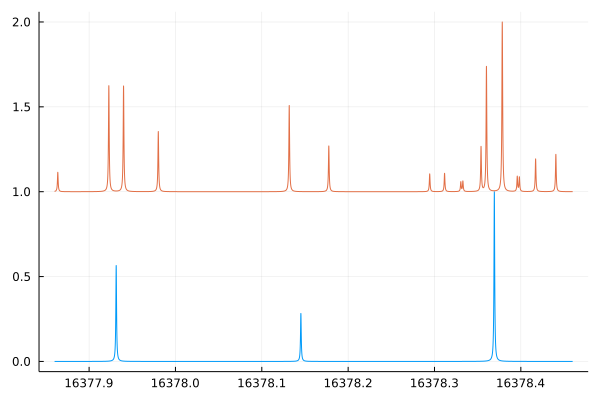

In [22]:
# Build ground state
@unpack B, γ, gS = MolParams["SrOH"]["X000"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr
bounds_X = (I=1/2, J=1/2:101/2, F = 0:9, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, γ, gS, gl = MolParams["SrOH"]["B000"]
Ho = T0 * Origin
Hrot = B * Rotation
Hsr = γ * SpinRotation
HB_zeem = gS * Zeeman_S + gl * Zeeman_gl
HB = Ho+Hrot+Hsr
bounds_B = (I=1/2, J=1/2:101/2, F = 0:9, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


plot()
for (nB,B) = enumerate(range(0, step=913.0, length=2))
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -9:9)
    excited = makeBlockedState(LinearCaseA_Field, HB+μB*B*HB_zeem, bounds_B, :M, -9:9)

    # Make linelist
    lout = makeLineList(ground,excited,"perp"; TK=20)
    freq, amp = plotLineList(lout, 16377.86,16378.46; gamma=0.001, nstep= 50000)
    plot!(freq, amp/maximum(amp) .+ 1*(nB-1))
end

plot!(legend=false)

# CaF

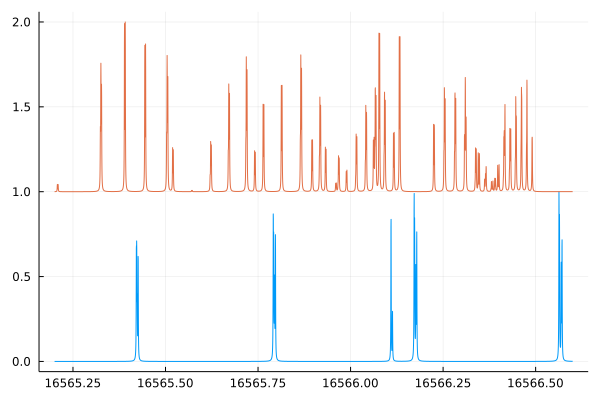

In [23]:
# Build ground state
@unpack B, γ, bF, c, gS = MolParams["CaF"]["X"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
Hhf = bF * Hyperfine_IF + c * Hyperfine_Dipolar_c
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr+Hhf
bounds_X = (J = 1/2:13/2, I=1/2, F=0:6, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, aSO, p2q, gS, gL, gl′ = MolParams["CaF"]["A"]
Ho = T0 * Origin
Hrot = B * Rotation
HSO = aSO * SpinOrbit
Hld = p2q * ΛDoubling_p2q
HA_zeem = gS*Zeeman_S + gL*Zeeman_L + gl′*Zeeman_parity
HA = Ho+Hrot+HSO+Hld 
bounds_A = (J = 1/2:13/2, I=1/2, F = 0:5, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2,3/2,-3/2],S = 1/2)


plot()
for (nB,B) = enumerate(range(0, step=3163.0, length=2))
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -5:5)
    excited = makeBlockedState(LinearCaseA_Field, HA+μB*B*HA_zeem, bounds_A, :M, -5:5)

    # Make linelist
   lout = makeLineList(ground,excited,"perp"; TK=10)
   freq, amp = plotLineList(lout, 16565.2, 16566.6; gamma=0.001, nstep= 5000)
   plot!(freq, amp/maximum(amp) .+ 1*(nB-1))
end

plot!(legend=false)


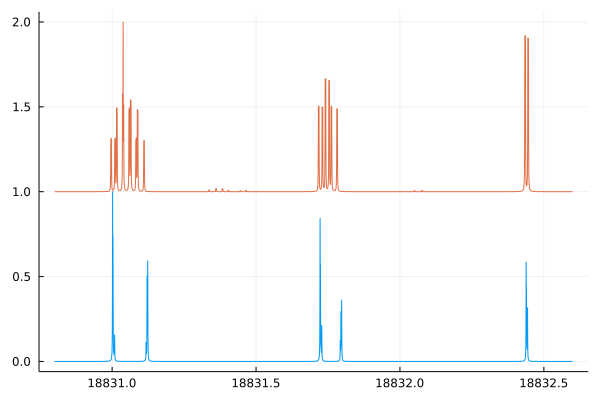

In [24]:
# Build ground state
@unpack B, γ, bF, c, gS = MolParams["CaF"]["X"]
Hrot = B * Rotation
Hsr = γ * SpinRotation
Hhf = bF * Hyperfine_IF + c * Hyperfine_Dipolar_c
HX_zeem = gS * Zeeman_S
HX = Hrot+Hsr+Hhf
bounds_X = (I=1/2, J=1/2:101/2, F = 0:9, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


# Build excited state
@unpack T0, B, γ, gS, gl = MolParams["CaF"]["B"]
Ho = T0 * Origin
Hrot = B * Rotation
Hsr = γ * SpinRotation
HB_zeem = gS * Zeeman_S + gl * Zeeman_gl
HB = Ho+Hrot+Hsr
bounds_B = (I=1/2, J=1/2:101/2, F = 0:9, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2)


plot()
for (nB,B) = enumerate(range(0, step=3163.0, length=2))
    ground = makeBlockedState(LinearCaseA_Field, HX+μB*B*HX_zeem, bounds_X, :M, -9:9)
    excited = makeBlockedState(LinearCaseA_Field, HB+μB*B*HB_zeem, bounds_B, :M, -9:9)

    # Make linelist
    lout = makeLineList(ground,excited,"par"; TK=10)
    freq, amp = plotLineList(lout, 18830.8, 18832.6; gamma=0.001, nstep= 50000)
    plot!(freq, amp/maximum(amp) .+ 1*(nB-1))
end

plot!(legend=false)